#  Modeling noise in $\alpha$

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import sys
sys.path.insert(0, '../../')
import mwc.viz
import mwc.stats
import mwc.bayes
mwc.viz.personal_style()

$$
\langle (I_1 - I_2 )^2 \rangle = \alpha I_\text{tot}
$$


### Model I - No noise.

$$
I_{tot} = \alpha N_{tot}
$$



### Model II -  Normal measurement noise

$$
I_{tot} = \alpha N_{tot}  + \epsilon\, ;\, \epsilon \sim \mathcal{N}(0, \sigma)
$$


### Model III - Cellular noise

$$
I_{tot} = \sum\limits_i^N \alpha_i + \epsilon_i \,;\, \epsilon \sim \mathcal{N}(0, \sigma)
$$

### Model IV - Cellular and measurement noise

$$
I_{tot} = \gamma * \sum\limits_i^N \alpha_i + \epsilon_i\, ;\, \epsilon \sim \mathcal{N}(0, \sigma)\, ;\, \gamma \sim \mathcal{N}(1, \zeta)
$$


In [107]:
# Set up some cells. 
n_div = 1000
ntot = np.random.gamma(2, 200, size=n_div).astype(int)
n1 = np.random.binomial(ntot, p=0.5)
n2 = ntot - n1

# Set up the models for alpha.
alpha_true = 100
epsilon = 0.000 * alpha_true
gamma = 0.005 * alpha_true

i1_mod1 = alpha_true * n1
i2_mod1 = alpha_true * n2

i1_mod2 = alpha_true * n1 + np.random.normal(0, epsilon, size=n_div)
i2_mod2 = alpha_true * n2 + np.random.normal(0, epsilon, size=n_div)

i1_mod3 = np.array([np.sum(alpha_true + np.random.normal(0, epsilon, n)) for n in n1])
i2_mod3 = np.array([np.sum(alpha_true + np.random.normal(0, epsilon, n)) for n in n2])

i1_mod4 = np.random.normal(1, gamma, size=n_div) * np.array([np.sum(alpha_true + np.random.normal(0, epsilon, n)) for n in n1])
i2_mod4 = np.random.normal(1, gamma, size=n_div) * np.array([np.sum(alpha_true + np.random.normal(0, epsilon, n)) for n in n2])

# Combine into a data frame. 
models = [[i1_mod1, i2_mod1], [i1_mod2, i2_mod2], [i1_mod3, i2_mod3], [i1_mod4, i2_mod4]]
dfs = []
for i, m in enumerate(models):
    i1, i2 = m
    df = pd.DataFrame(np.array([i1, i2, i1 + i2, (i1 - i2)**2]).T, columns=['i1', 'i2', 'summed', 'fluct'])
    df.insert(0, 'model', i + 1)
    dfs.append(df)
    
df = pd.concat(dfs, ignore_index=True)
df = df[df > 0]
df.dropna(inplace=True)

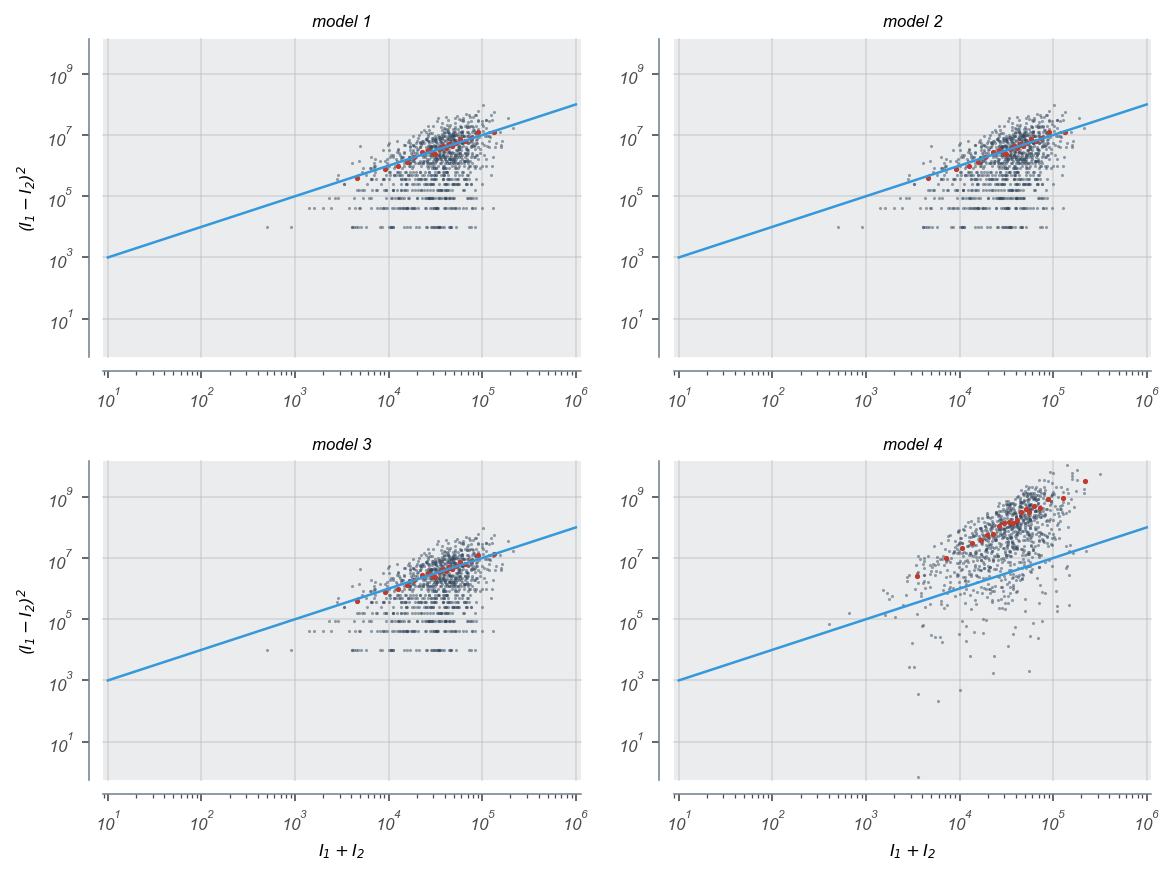

In [108]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()
for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    
I_tot_range = np.logspace(1, 6, 500)
bin_size = 50
grouped = df.groupby('model')
for g, d in grouped:
    # Bin the data. 
    binned = mwc.stats.bin_by_events(d, bin_size)
    ax[g - 1].plot(d['summed'], d['fluct'], '.', ms=1, alpha=0.5)
    ax[g - 1].plot(binned['summed'], binned['fluct'], '.', ms=3)
    ax[g - 1].plot(I_tot_range, alpha_true * I_tot_range)
    ax[g - 1].set_title('model {}'.format(g))


ax[0].set_ylabel('($I_1 - I_2)^2$')
ax[2].set_ylabel('($I_1 - I_2)^2$')
ax[2].set_xlabel('$I_1 + I_2$')
ax[3].set_xlabel('$I_1 + I_2$')

sns.despine(offset=7)
plt.tight_layout()

In [109]:
# Fit alpha to each case.
traces = []
stat_dfs = []
for g, d in grouped:
    
    with pm.Model() as model: 
        like = mwc.bayes.DeterminsticCalibrationFactor('alpha', testval=1, I_1=d['i1'].values, I_2=d['i2'].values)
        trace = pm.sample(tune=5000, draw=5000)
        traces.append(trace)
        trace_df = mwc.stats.trace_to_dataframe(trace, model)
        stats = mwc.stats.compute_statistics(trace_df)                                                                                          
        stats.insert(0, 'model', d.model.unique())
        stat_dfs.append(stats)
stats = pd.concat(stat_dfs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
100%|██████████| 5500/5500 [00:05<00:00, 1016.15it/s]
The acceptance probability does not match the target. It is 0.881315961257, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883206998197, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
100%|██████████| 5500/5500 [00:05<00:00, 984.72it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
100%|██████████| 5500/5500 [00:05<00:00, 1004.75it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
100%|█████

In [110]:
stats

,model,parameter,mode,hpd_min,hpd_max
0,1,alpha,101.368902,92.697413,110.169153
0,2,alpha,101.381892,93.573829,111.824681
0,3,alpha,101.383210,93.059482,110.709898
0,4,alpha,4373.017126,4048.826113,4769.045635


In [97]:
np.random.normal(1, 0.0045, 1000)

array([ 0.99915683,  0.99800752,  1.00239671,  1.00436211,  0.99502973,
        1.00001681,  0.99822566,  1.00643241,  1.00580123,  1.00350793,
        0.99831723,  0.99992493,  1.00725902,  1.00445466,  1.00010942,
        0.99172204,  1.0031923 ,  1.00133553,  1.00110692,  0.99632535,
        0.99089808,  0.99885921,  0.99859763,  0.99447368,  1.00037285,
        1.00283828,  0.99805058,  0.99512363,  0.99347121,  1.00192028,
        1.00107857,  1.00315902,  1.00050317,  1.01152571,  1.00056974,
        1.00226486,  1.00256744,  1.00270648,  1.00267547,  0.99574665,
        1.0012387 ,  0.99451722,  0.99588255,  1.00246601,  0.99309783,
        1.00231401,  0.99712552,  0.99694466,  1.00188579,  1.00440518,
        0.99949235,  1.00348534,  0.99940686,  1.00315851,  1.00119038,
        1.00648914,  1.00438357,  1.00569819,  0.9994725 ,  1.00005102,
        0.98907157,  1.00330683,  1.00834968,  1.00301197,  1.00579241,
        1.00153107,  0.99748502,  0.99912049,  0.99952513,  0.99